In [114]:
import sys
sys.path.insert(0, "../")

from datasets import load_dataset
from omegaconf import OmegaConf

import numpy as np
import torch
from einops import rearrange
from huggingface_hub import hf_hub_download
from IPython.utils import io
from torch.utils.data import DataLoader

from ldm.util import instantiate_from_config
from utils import collate_fn

from PIL import Image

from large_image_gen.resizer import Resizer
from large_image_gen.utils import model_pred, decode_large_image

import torch.nn.functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

## Load Dataset

In [2]:
MAG = "5x" # The sample dataset has 20x, 10x, 5x, 2_5x and 1_25x data

ds = load_dataset("StonyBrook-CVLab/ZoomLDM-demo-dataset", name=MAG, trust_remote_code=True, split='train')
dl = DataLoader(ds, batch_size=1, shuffle=True, collate_fn = collate_fn)

In [ ]:
batch = next(iter(dl))

# Images are always 256x256
print("Images:", batch['image'].shape)

# Magnification is encoded into 0-4
MAG_DICT = {
    "20x": 0,
    "10x": 1,
    "5x": 2,
    "2_5x": 3,
    "1_25x": 4,
}
print("Magnifications:", batch['mag'])

# We extract an SSL embedding for each 20x patch in the image and arrange them spatially
# e.g. 5x -> (4,4) SSL embeddings
# For magnifications that end up with more than (8,8) embeddings we average them down to (8,8)
# We are going to use the unpooled features here to generate all 20x patches
print("SSL Features:", batch['ssl_feat_unpooled'].shape)

Images: torch.Size([1, 256, 256, 3])
Magnifications: tensor([2])
SSL Features: torch.Size([1, 1024, 4, 4])


## Load ZoomLDM

In [4]:
device = torch.device('cuda:1')
torch.cuda.set_device(1)

ckpt_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="brca/weights.ckpt")
state_dict = torch.load(ckpt_path, weights_only=False)

config_path = hf_hub_download(repo_id="StonyBrook-CVLab/ZoomLDM", filename="brca/config.yaml")
config = OmegaConf.load(config_path)

with io.capture_output() as _:
    model = instantiate_from_config(config.model)
model = model.to(device).eval()
model.load_state_dict(state_dict);

# disable null token 
model.cond_stage_model.p_uncond = 0

## Joint multi-scale sampling

In [ ]:
# Diffusion parameters
t0 = 1000
stride = 50
print("Total steps", t0//stride)

guidance = 2
batch_size = 16 # Reduce if GPU memory is limited

# Consisntecy between scales
h = 0.005 # delta constant for numerical approximation
lr = 0.5 # Learning rate

# Number of steps
# Decrease for speed -- less faithful to the lower magnification
# 5x: we find that 10 works well
# 1.25x: we can use 1 to make generation fast
n_steps = 10

In [ ]:
# Get all 20x SSL features
ssl_feat = batch['ssl_feat_unpooled'][0].float().to(device)

# Decide lower magnification conditioning shape
if MAG == "10x":
    emb_h, emb_w = 2, 2
elif MAG == "5x":
    emb_h, emb_w = 4, 4
elif MAG == "2_5x":
    emb_h, emb_w = 8, 8
elif MAG == "1_25x":
    emb_h, emb_w = 16, 16

# Rearrange SSL embeddings for each magnification and extract conditioning from the summarizer
with torch.no_grad():
    # Highest resolution generation at 20x
    ssl_feat_20x = rearrange(ssl_feat, 'd (p1 h) (p2 w) -> (p1 p2) d h w', p1=emb_h, p2=emb_w)
    cond_dict_20x = dict(ssl_feat=[ssl_feat_20x[i] for i in range(ssl_feat_20x.shape[0])],
                         mag=torch.tensor([MAG_DICT["20x"]]).long().tile(ssl_feat_20x.shape[0]).to(device))
    cond_20x_all = model.get_learned_conditioning(cond_dict_20x)

    # Guiding scale generation
    if emb_h > 8 and emb_w > 8:
        # Pool if larger than (8,8)
        ssl_feat_guide = F.adaptive_avg_pool2d(ssl_feat.unsqueeze(0), (8,8))
    else:
        ssl_feat_guide = ssl_feat.unsqueeze(0)

    cond_dict_guide = dict(ssl_feat=[ssl_feat_guide[i] for i in range(ssl_feat_guide.shape[0])],
                           mag=torch.tensor([MAG_DICT[MAG]]).long().tile(ssl_feat_guide.shape[0]).to(device))
    cond_guide = model.get_learned_conditioning(cond_dict_guide)

# Downsampling/Upsampling operator
down_operator = Resizer((1,3,256,256), scale_factor=1/emb_h).to(device)
up_operator = Resizer((1,3,256//emb_h,256//emb_w), scale_factor=emb_h).to(device)

In [ ]:
## Generate

# Initial noise
xt_20x_all = torch.randn((emb_h*emb_w,3,64,64), device=device)
xt_guide = torch.randn((1,3,64,64), device=device)

for idx, t in tqdm(enumerate(range(t0, 0, -stride)), total=t0//stride):
    # Schedule parameters
    atbar = model.alphas_cumprod[t-1].view(1,1,1,1).to(device)
    atbar_prev = model.alphas_cumprod[max(t-1-stride,0)].view(1,1,1,1).to(device)
    beta_tilde = (model.betas[t-1] * (1 - atbar_prev) / (1 - atbar)).view(1,1,1,1).to(device)

    # Denoise guide image (lower magnification)
    epsilon_guide = model_pred(model, xt_guide, t, cond_guide, w=guidance)
    x0_pred_guide = xt_guide / torch.sqrt(atbar) - epsilon_guide * torch.sqrt((1-atbar)/atbar)
    img_pred_guide = model.decode_first_stage(x0_pred_guide).clamp(-1,1)
    
    # Denoise all patches at 20x
    x0_pred_20x_all = []
    eps_20x_all = []
    for idx_20x in range(0, xt_20x_all.shape[0], batch_size):
        # Select patches
        xt_20x = xt_20x_all[idx_20x:idx_20x+batch_size,...]
        cond_20x = cond_20x_all[idx_20x:idx_20x+batch_size,...]
        img_patches_guide = rearrange(img_pred_guide, 'b c (p1 h) (p2 w) -> (b p1 p2) c h w', p1=emb_h, p2=emb_w)[idx_20x:idx_20x+batch_size,...]

        # Predict noise for 20x
        epsilon_20x = model_pred(model, xt_20x, t, cond_20x, w=guidance)
        x0_pred_20x = xt_20x / torch.sqrt(atbar) - epsilon_20x * torch.sqrt((1-atbar)/atbar)
        img_pred_20x = model.decode_first_stage(x0_pred_20x).clamp(-1,1)

        # Enforce consistency between guide and 20x patches
        for k in range(n_steps):
            # Reference for algorithm: https://github.com/cvlab-stonybrook/fast-constrained-sampling/blob/main/stable-diffusion/superres_vae_newton.ipynb
            # Compute error in image space
            img_pred = model.decode_first_stage(x0_pred_20x)
            z = model.get_first_stage_encoding(model.encode_first_stage(img_pred))

            img_error_dir = up_operator(img_patches_guide - down_operator(img_pred))
            img_error_dir = img_error_dir / img_error_dir.abs().reshape(xt_20x.shape[0],-1).max(1)[0].view(-1,1,1,1)

            z_perturbed = model.get_first_stage_encoding(model.encode_first_stage(img_pred + h*img_error_dir))
            error_dir = (z_perturbed - z)
            error_dir = error_dir / error_dir.abs().reshape(xt_20x.shape[0],-1).max(1)[0].view(-1,1,1,1)

            # Compute gradient
            xt_error_dir = xt_20x + h*error_dir
            epsilon_error_dir = model_pred(model, xt_error_dir, t, cond_20x, w=guidance)
            x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)
            grad = (x0_pred_error_dir - x0_pred_20x) / h

            # Normalize grad by inf-norm
            max_grad = grad.abs().reshape(xt_20x.shape[0],-1).max(1)[0].view(-1,1,1,1)
            grad = grad / max_grad
        
            # Update 20x patches
            xt_20x = xt_20x + lr*grad
        
            epsilon_20x = model_pred(model, xt_20x, t, cond_20x, w=guidance)
            x0_pred_20x = xt_20x / torch.sqrt(atbar) - epsilon_20x * torch.sqrt((1-atbar)/atbar)
            
        # Once finished, add to list of 20x patches we are generating
        x0_pred_20x_all.append(x0_pred_20x)
        eps_20x_all.append(epsilon_20x)

    # Collect patches
    x0_pred_20x_all = torch.cat(x0_pred_20x_all, dim=0)
    eps_20x_all = torch.cat(eps_20x_all, dim=0)

    # Perform denoising step
    xt_20x_all = torch.sqrt(atbar_prev)*x0_pred_20x_all + torch.sqrt(1-atbar_prev)*eps_20x_all + torch.sqrt(beta_tilde)*torch.randn_like(xt_20x_all)
    xt_guide = torch.sqrt(atbar_prev)*x0_pred_guide + torch.sqrt(1-atbar_prev)*epsilon_guide + torch.sqrt(beta_tilde)*torch.randn_like(xt_guide)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [05:17<00:00, 15.87s/it]


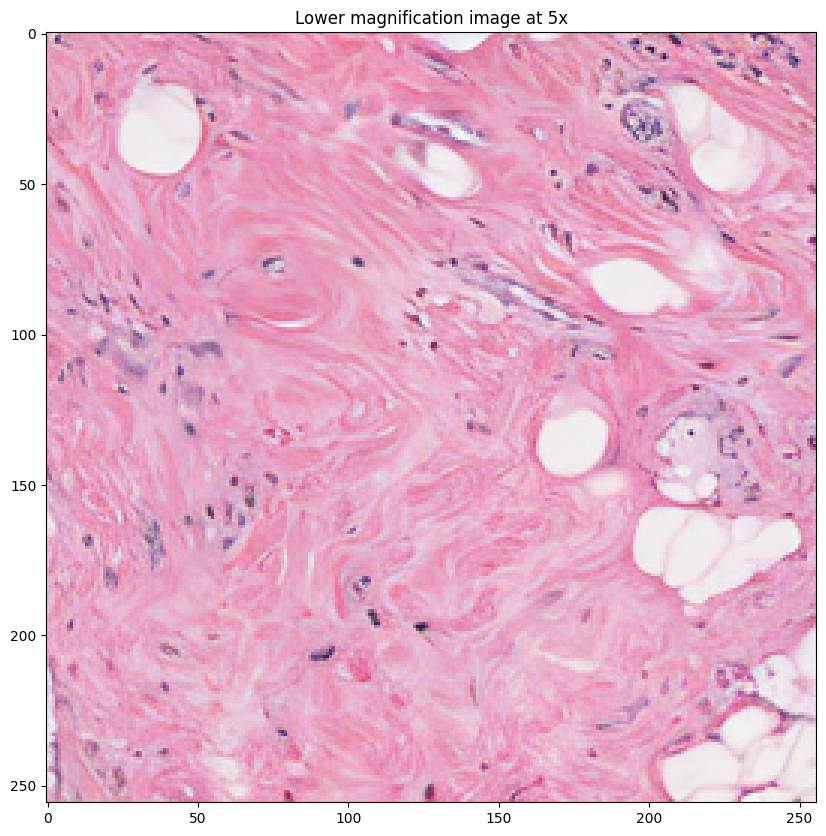

In [ ]:
image_guide = model.decode_first_stage(xt_guide)
image_guide = (0.5*(image_guide+1)).clamp(0,1).cpu().numpy().transpose([0,2,3,1])
image_guide = (255*image_guide).astype(np.uint8)

plt.figure(figsize=(10,10))
plt.imshow(image_guide[0])
plt.title(f'Lower magnification image at {MAG}')
plt.show()

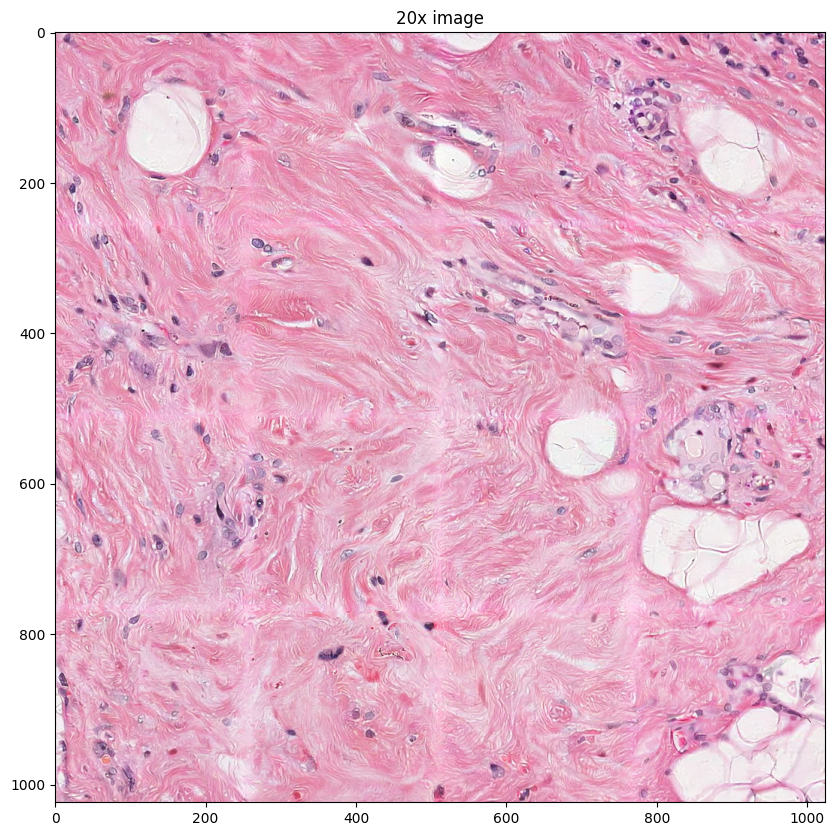

In [ ]:
# Rearrange into one image and decode
xt_20x = rearrange(xt_20x_all, '(b p1 p2) c h w -> b c (p1 h) (p2 w)', p1=emb_h, p2=emb_w)
image_20x = decode_large_image(xt_20x, model)

plt.figure(figsize=(10,10))
plt.imshow(image_20x[0])
plt.title('20x image')
plt.show()

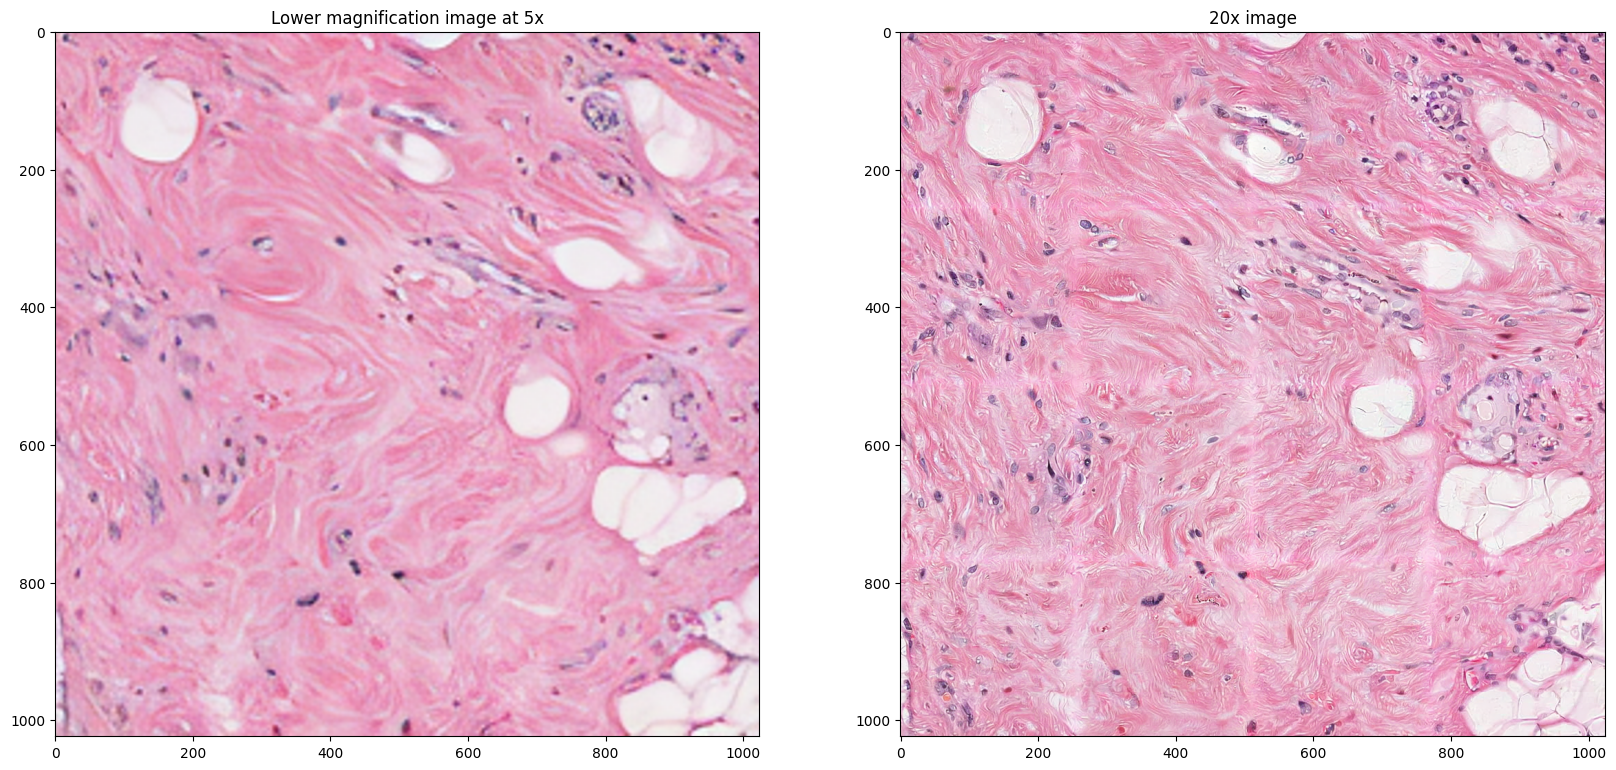

In [108]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(Image.fromarray(image_guide[0]).resize((1024,1024)))
ax[0].set_title(f'Lower magnification image at {MAG}')
ax[1].imshow(Image.fromarray(image_20x[0]))
ax[1].set_title('20x image')
plt.show()

## (Optional) Postprocessing

In [115]:
from large_image_gen.postprocess import postprocess_image

# We postprocess the image by adding noise and denoising at 20x
# This eliminates border artifacts
t0 = 300 # Adding more noise can alter the content of the image, deviating from the lower magnification guide
stride = 50
guidance = 2

ssl_feat = batch['ssl_feat_unpooled'][0].float().to(device)
xt_20x_all_postprocessed = postprocess_image(
    model, xt_20x_all, ssl_feat,
    t0, stride, guidance,
    sliding_window_size=16, emb_h=emb_h, emb_w=emb_w, batch_size=16)

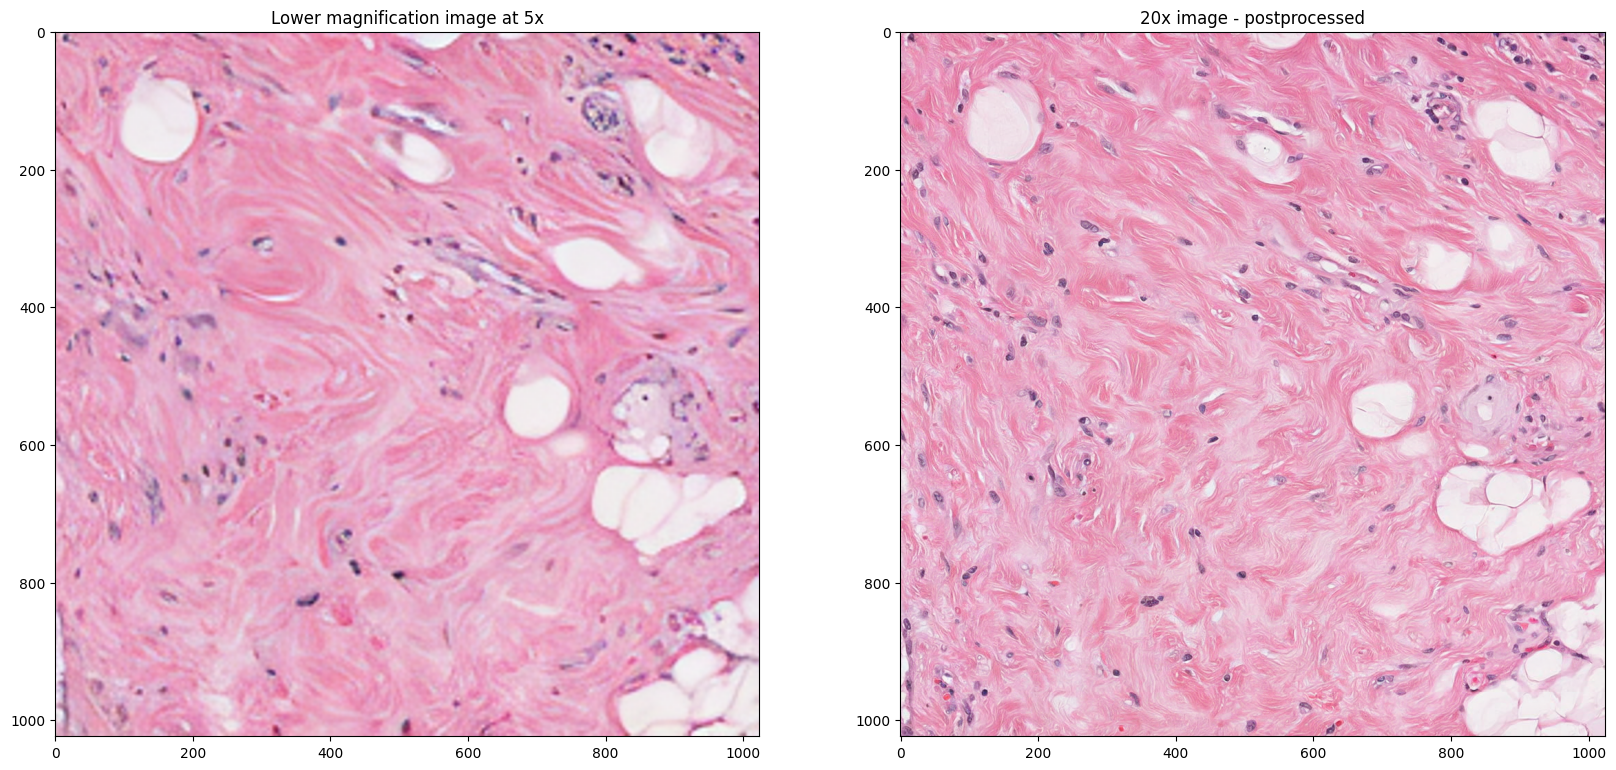

In [116]:
xt_20x_postprocessed = rearrange(xt_20x_all_postprocessed, '(b p1 p2) c h w -> b c (p1 h) (p2 w)', p1=emb_h, p2=emb_w)
image_20x_postprocessed = decode_large_image(xt_20x_postprocessed, model)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(Image.fromarray(image_guide[0]).resize((1024,1024)))
ax[0].set_title(f'Lower magnification image at {MAG}')
ax[1].imshow(Image.fromarray(image_20x_postprocessed[0]))
ax[1].set_title('20x image - postprocessed')
plt.show()